# Before we begin

* Github (Github Education)
* Bitbucket
* Kaggle

# Introduction
In this week, we want to implement an Ant Colony Optimization Algorithm to solve Travelling Sales Man problem.

In [1]:
import random
import math
import operator
import matplotlib.pyplot as plt

# Content
* Travelling Sales Man Problem
* Helper Functions
* Cost & Pheromone Graph
* Designing Ants
* Designing ACO
* Running

# Travelling Sales Man Problem(TSP)

The travelling salesman problem (TSP) asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?" It is an NP-hard problem in combinatorial optimization, important in operations research and theoretical computer science.

![TSP Sample](figs/tsp.png)

# Helper Functions

\begin{align}
Distance = \sqrt{ (y_2 - y_1)^2 + (x_2 - x_1)^2}
\end{align}

In [2]:
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

In [3]:
def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y)) # for better visualization
    plt.plot(x, y, 'co')

    for k in range(1, len(path)):
        i = path[k - 1] # index of first city
        j = path[k] # index of next city
        
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)

    
    plt.xlim(0, max(x) * 1.1)
    
    plt.ylim(0, max(y) * 1.1)
    
    plt.show()

# Prerequisites

### ACO Algorihtm
![ACO Algorithm](figs/aco_algorithm.PNG)
### Strategy
![Q Updating](figs/strategy.PNG)
With $Q \in [0,1]$
### Rho
\begin{align}
T_{ij}(t) \leftarrow rho * T_{ij}(t)
\end{align}
With $rho \in [0,1]$
### Transition Probability
![Transition Probability](figs/transition_prob.PNG)
With $\alpha, \beta \in [0,1]$

# Cost & Pheromone Graph

The graph is a data structure that has the matrices that we needed to evaluate transition probability:

In [4]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        # noinspection PyUnusedLocal
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]

# Designing Ants

In [5]:
class Ant(object):
    def __init__(self, aco, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.path = []  # path
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] \
                        for i in range(graph.rank)]  # heuristic information for calculating 
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.path.append(start)
        self.current = start
        self.allowed.remove(start)

    def select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha \
                * self.eta[self.current][i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
            
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.path.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for k in range(1, len(self.path)):
            i = self.path[k - 1]
            j = self.path[k]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

# Designing ACO

In [6]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int,
                 alpha: float, beta: float, rho: float,
                 q: int, strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho # Evapuration Rate
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho # Evapuration
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant.select_next()
                ant.total_cost += graph.matrix[ant.path[-1]][ant.path[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.path
                # update pheromone
                ant.update_pheromone_delta()
            self._update_pheromone(graph, ants)
            print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost

# Running

generation #0, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14]
generation #1, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14]
generation #2, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14]
generation #3, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14]
generation #4, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14]
generation #5, best cost: 17120.042816344583, path: [9, 8, 7, 1, 3, 4, 5, 6, 12, 11, 13, 10, 22, 15, 16, 18, 23, 24, 19, 20, 21, 17, 2, 25, 27, 26, 30, 29, 28, 0, 14

generation #49, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #50, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #51, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #52, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #53, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #54, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14,

generation #98, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
generation #99, best cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]
cost: 16970.978236089806, path: [30, 29, 26, 27, 25, 20, 21, 17, 2, 16, 18, 23, 19, 24, 10, 11, 13, 12, 6, 5, 4, 3, 1, 15, 22, 7, 8, 9, 14, 0, 28]


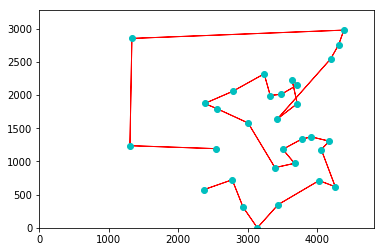

In [7]:
def main():
    # Loading Data from files
    cities = []
    points = []
    with open('./data/chn31.txt') as f:
        for line in f.readlines():
            city = line.split(' ')
            cities.append(dict(index=int(city[0]), x=int(city[1]), y=int(city[2])))
            points.append((int(city[1]), int(city[2])))
    
    # Calculating Cost matrix => distance between city i and j
    cost_matrix = []
    rank = len(cities)
    for i in range(rank):
        row = []
        for j in range(rank):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)
        
    # Instaniate ACO, and Run
    aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 2)
    graph = Graph(cost_matrix, rank)
    path, cost = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    
    # Ploting the best cycle found
    plot(points, path)

if __name__ == '__main__':
    main()